# Импорты

In [26]:
%%time
# здесь будем ставить все, чего нам не хватает
# !pip install missingno -q
# !pip install optuna -q
# !pip install tqdm -q
# !pip install seaborn -q
# !pip install torch -q
# !pip install scikit-learn -q
# !pip install statsmodels -q

CPU times: total: 0 ns
Wall time: 3.58 μs


In [27]:
import pandas as pd
import psycopg2
import logging
from sqlalchemy import create_engine
import sqlalchemy
import time
import socket
import sys
import numpy as np
import matplotlib.pyplot as plt

# === Функции проекта ===
from func import (
    check_data,
    drop_duplicated,
    plot_combined,
    calc_target_correlations,
    plot_categorical_columns,
    plot_scatter_with_numerical
)

from creds import db_config

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
logger = logging.getLogger(__name__)

# Подключение к базе и получение данных

In [28]:
# Импортируем конфигурацию из отдельного файла
try:
    logger.info("Конфигурация загружена из creds.py")
except ImportError:
    logger.info("Файл creds.py не найден")
    db_config = {
        'user': input("Введите имя пользователя: "),
        'pwd': input("Введите пароль: "),
        'host': input("Введите хост: "),
        'port': input("Введите порт: "),
        'db': input("Введите название БД: ")
    }

2025-11-26 12:21:27 [INFO] __main__: Конфигурация загружена из creds.py


In [29]:
def check_host_availability():
    """Проверка доступности хоста"""
    try:
        socket.create_connection((db_config['host'], db_config['port']), timeout=10)
        logger.info("Хост доступен")
        return True
    except socket.error as e:
        logger.info(f"Хост недоступен: {e}")
        sys.exit("ОСТАНОВКА: Не удалось подключиться к базе данных. Дальнейшее выполнение невозможно.")

check_host_availability()

2025-11-26 12:21:27 [INFO] __main__: Хост доступен


True

Хост доступен, можем подключаться и загружать данные.   

In [30]:
# если с хостом все ок, то подключаемся и забираем данные
connection_string = f"postgresql://{db_config['user']}:{db_config['pwd']}@{db_config['host']}:{db_config['port']}/{db_config['db']}"
engine = create_engine(connection_string)

def load_data_safe(engine, table_name_or_query, use_chunks=True, chunksize=300000):
    """Загружает данные - либо таблицу целиком, либо по SQL-запросу"""
    try:
        # Определяем тип загрузки
        if isinstance(table_name_or_query, str) and table_name_or_query.strip().upper().startswith('SELECT'):
            # Это SQL-запрос - загружаем напрямую
            logger.info(f"Загружаем данные по SQL-запросу...")
            result = pd.read_sql(table_name_or_query, engine)
            logger.info(f"Загружено: {result.shape[0]} строк, {result.shape[1]} столбцов")
            return result
        else:
            # Это имя таблицы
            table_name = table_name_or_query
            if use_chunks:
                # Загружаем по частям
                logger.info(f"Загружаем таблицу {table_name} по частям...")
                count_query = f"SELECT COUNT(*) FROM {table_name}"
                total_rows = pd.read_sql(count_query, engine).iloc[0,0]
                logger.info(f"Всего строк в {table_name}: {total_rows}")
                
                chunks = []
                for offset in range(0, total_rows, chunksize):
                    query = f"SELECT * FROM {table_name} LIMIT {chunksize} OFFSET {offset}"
                    chunk = pd.read_sql(query, engine)
                    chunks.append(chunk)
                    logger.info(f"Загружено {len(chunk)} строк (прогресс: {min(offset + chunksize, total_rows)}/{total_rows})")
                
                result = pd.concat(chunks, ignore_index=True)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
            else:
                # Загружаем целиком
                logger.info(f"Загружаем таблицу {table_name}...")
                result = pd.read_sql(f"SELECT * FROM {table_name}", engine)
                logger.info(f"{table_name}: {result.shape[0]} строк, {result.shape[1]} столбцов")
                return result
        
    except Exception as e:
        logger.error(f"Ошибка при загрузке: {e}")
        return None

def load_all_tables_safe(engine, tables_config):
    """Безопасная загрузка всех таблиц/запросов"""
    dataframes = {}
    
    for table_name, table_ref in tables_config.items():
        dataframes[table_name] = load_data_safe(engine, table_ref)
    
    return dataframes

In [31]:
logger.info("=== ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===")
full_tables_config = {
    'collisions': 'collisions',
    'parties': 'parties', 
    'vehicles': 'vehicles'
}

df_dict_full = load_all_tables_safe(engine, full_tables_config)

# Проверяем что все таблицы загружены
successful_tables = {k: v for k, v in df_dict_full.items() if v is not None}

if len(successful_tables) == len(full_tables_config):
    collisions_default = df_dict_full['collisions']
    parties_default = df_dict_full['parties']
    vehicles_default = df_dict_full['vehicles']
    logger.info("Все полные данные успешно загружены")
else:
    logger.warning(f"Загружены только таблицы: {list(successful_tables.keys())}")

2025-11-26 12:21:27 [INFO] __main__: === ЗАГРУЗКА ПОЛНЫХ ТАБЛИЦ ===
2025-11-26 12:21:27 [INFO] __main__: Загружаем таблицу collisions по частям...
2025-11-26 12:21:28 [INFO] __main__: Всего строк в collisions: 1400000
2025-11-26 12:21:35 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/1400000)
2025-11-26 12:21:43 [INFO] __main__: Загружено 300000 строк (прогресс: 600000/1400000)
2025-11-26 12:21:51 [INFO] __main__: Загружено 300000 строк (прогресс: 900000/1400000)
2025-11-26 12:21:58 [INFO] __main__: Загружено 300000 строк (прогресс: 1200000/1400000)
2025-11-26 12:22:04 [INFO] __main__: Загружено 200000 строк (прогресс: 1400000/1400000)
2025-11-26 12:22:04 [INFO] __main__: collisions: 1400000 строк, 20 столбцов
2025-11-26 12:22:04 [INFO] __main__: Загружаем таблицу parties по частям...
2025-11-26 12:22:04 [INFO] __main__: Всего строк в parties: 2752408
2025-11-26 12:22:07 [INFO] __main__: Загружено 300000 строк (прогресс: 300000/2752408)
2025-11-26 12:22:10 [INFO] __main__: З

In [32]:
collisions_default.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0.0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1.0,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1.0,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [33]:
parties_default.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0


In [34]:
vehicles_default.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3.0
1,1,3858022,1,sedan,auto,3.0
2,1175712,5305030,1,sedan,auto,3.0
3,1175717,5305033,3,sedan,auto,5.0
4,1175722,5305034,2,sedan,auto,5.0


Да, много данных. Посмотрим, как это число изменится если мы сразу получим только то, что нам нужно

В тз у нас есть ограничения на выборку - учтем их сразу в запросах, чтобы не тащить все данные.  
- Для модели выбрать тип виновника — только машина (car).  
- Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).  
- Для моделирования ограничиться данными за 2012 год — они самые свежие.  

Также отберем только нужные признаки, который будут полезны для модели.

# Отбор признаков для модели предсказания виновности в ДТП

## Признаки для модели

Из таблицы `collisions`

| Признак | Обоснование |
|---------|-------------|
| `WEATHER_1` | Погодные условия напрямую влияют на видимость и управляемость транспортным средством |
| `ROAD_SURFACE` | Состояние дорожного покрытия значительно воздействует на риск возникновения ДТП |
| `LIGHTING` | Уровень освещённости влияет на видимость и скорость реакции водителя |
| `INTERSECTION` | Перекрестки являются зонами повышенной аварийности и сложности манёвров |
| `LOCATION_TYPE` | Тип дороги определяет характер движения и потенциальные риски |
| `PCF_VIOLATION_CATEGORY` | Ключевой признак - категории нарушений ПДД напрямую коррелируют с виновностью |
| `TYPE_OF_COLLISION` | Тип столкновения может указывать на действия виновника аварии |
| `ROAD_CONDITION_1` | Дополнительные дорожные условия создают дополнительные факторы риска |

Из таблицы `parties`

| Признак | Обоснование |
|---------|-------------|
| `PARTY_DRUG_PHYSICAL` | Важный признак - физическое состояние водителя напрямую влияет на виновность |
| `PARTY_SOBRIETY` | Критический признак - состояние трезвости является ключевым фактором определения виновника |
| `CELLPHONE_IN_USE` | Использование телефона за рулём приводит к отвлечению внимания и нарушениям |

Из таблицы `vehicles`

| Признак | Обоснование |
|---------|-------------|
| `VEHICLE_AGE` | Обязателен по ТЗ - возраст автомобиля может влиять на техническую исправность и безопасность |
| `VEHICLE_TYPE` | Тип кузова может влиять на управляемость и поведение транспортного средства |

---

## Признаки для исключения из модели

Технические и идентификационные признаки
- `CASE_ID`, `ID` - уникальные идентификаторы, не несут прогнозной способности
- `PARTY_NUMBER` - технический номер участника в рамках ДТП

Географические признаки
- `COUNTY_CITY_LOCATION`, `COUNTY_LOCATION` - без детальных карт и анализа дорожной инфраструктуры сложно интерпретировать
- `DIRECTION` - направление движения само по себе не является информативным признаком

Временные признаки
- `COLLISION_DATE`, `COLLISION_TIME` - рекомендуется вынести в отдельный анализ сезонности и времени суток

Избыточные и производные признаки
- `PRIMARY_COLLISION_FACTOR` - дублирует информацию из `PCF_VIOLATION_CATEGORY`, но в более обобщённой форме
- `PARTY_COUNT` - количество участников ДТП слабо коррелирует с виновностью конкретного водителя
- `DISTANCE` - расстояние от главной дороги без дополнительного контекста не информативно
- `MOTOR_VEHICLE_INVOLVED_WITH` - тип второго участника менее важен, чем действия самого виновника
- `INSURANCE_PREMIUM` - страховая премия является скорее следствием, чем причиной ДТП

Поразмыслив - оставлю DIRECTION и DISTANCE, в целом также придерживаюсь, но оставим выбор за моделью.  
По тз есть задача оценить по месяцам, поэтому COLLISION_DATE пока тоже оставим  

In [35]:
logger.info("=== ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===")

# оптимизированные запросы с учетом отбора признаков
query = """
SELECT 
    -- Из collisions
    -- c.case_id,
    c.weather_1,
    c.road_surface,
    c.lighting,
    c.intersection,
    c.location_type,
    c.pcf_violation_category,
    c.type_of_collision,
    c.road_condition_1,
    c.direction,
    c.distance,
    c.collision_date,
    c.collision_time,
    
    -- Из parties
    p.party_number,
    p.at_fault,
    p.party_drug_physical,
    p.party_sobriety,
    p.cellphone_in_use,
    
    -- Из vehicles
    v.vehicle_type,
    v.vehicle_age,
    v.vehicle_transmission
    
FROM collisions c
JOIN parties p ON c.case_id = p.case_id
JOIN vehicles v ON c.case_id = v.case_id AND p.party_number = v.party_number
WHERE EXTRACT(YEAR FROM c.collision_date) = 2012
    AND c.collision_damage <> 'scratch'
    AND p.party_type = 'car'
    AND v.vehicle_age < 11
"""

filtered_tables_config = {
    'df': query
}

2025-11-26 12:22:41 [INFO] __main__: === ЗАГРУЗКА ОТФИЛЬТРОВАННЫХ ТАБЛИЦ ===


In [36]:
# Загружаем отфильтрованные таблицы
df_dict_filtered = load_all_tables_safe(engine, filtered_tables_config)

# Проверяем успешность загрузки и создаем переменные
successful_tables = {k: v for k, v in df_dict_filtered.items() if v is not None}

if len(successful_tables) == len(filtered_tables_config):
    df = df_dict_filtered['df']
    
    logger.info("Все отфильтрованные данные успешно загружены и готовы к анализу.")
    
else:
    logger.warning(f"Загружены не все таблицы. Успешно: {list(successful_tables.keys())}")
    
    # Создаем переменные только для успешно загруженных таблиц
    if 'df' in successful_tables:
        df = df_dict_filtered['df']

2025-11-26 12:22:41 [INFO] __main__: Загружаем данные по SQL-запросу...
2025-11-26 12:22:46 [INFO] __main__: Загружено: 51413 строк, 20 столбцов
2025-11-26 12:22:46 [INFO] __main__: Все отфильтрованные данные успешно загружены и готовы к анализу.


## Оценка df

### общие данные

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51413 entries, 0 to 51412
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   weather_1               51258 non-null  object 
 1   road_surface            51107 non-null  object 
 2   lighting                51267 non-null  object 
 3   intersection            51256 non-null  float64
 4   location_type           24139 non-null  object 
 5   pcf_violation_category  50737 non-null  object 
 6   type_of_collision       51143 non-null  object 
 7   road_condition_1        51191 non-null  object 
 8   direction               39866 non-null  object 
 9   distance                51413 non-null  float64
 10  collision_date          51413 non-null  object 
 11  collision_time          51333 non-null  object 
 12  party_number            51413 non-null  int64  
 13  at_fault                51413 non-null  int64  
 14  party_drug_physical     2550 non-null 

None

,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
37508,clear,dry,daylight,0.0,None,other hazardous violation,broadside,normal,east,2376.0,2012-04-23,07:50:00,1,1,None,had not been drinking,0.0,sedan,2,manual
49367,clear,dry,daylight,1.0,None,traffic signals and signs,broadside,normal,None,0.0,2012-04-15,09:30:00,2,0,None,had not been drinking,0.0,sedan,4,auto
29211,raining,wet,dark with street lights,0.0,None,automobile right of way,sideswipe,normal,north,20.0,2012-01-19,19:02:00,2,0,None,had not been drinking,0.0,sedan,2,auto
39791,raining,wet,daylight,0.0,None,unsafe starting or backing,rear end,normal,east,100.0,2012-03-18,15:40:00,1,1,None,had not been drinking,NaN,sedan,0,manual
34335,clear,dry,daylight,0.0,highway,improper turning,hit object,normal,north,528.0,2012-04-16,15:45:00,1,1,None,had not been drinking,0.0,sedan,3,manual


weather_1                   155
road_surface                306
lighting                    146
intersection                157
location_type             27274
pcf_violation_category      676
type_of_collision           270
road_condition_1            222
direction                 11547
collision_time               80
party_drug_physical       48863
party_sobriety              782
cellphone_in_use           3928
vehicle_transmission        535
dtype: int64

None

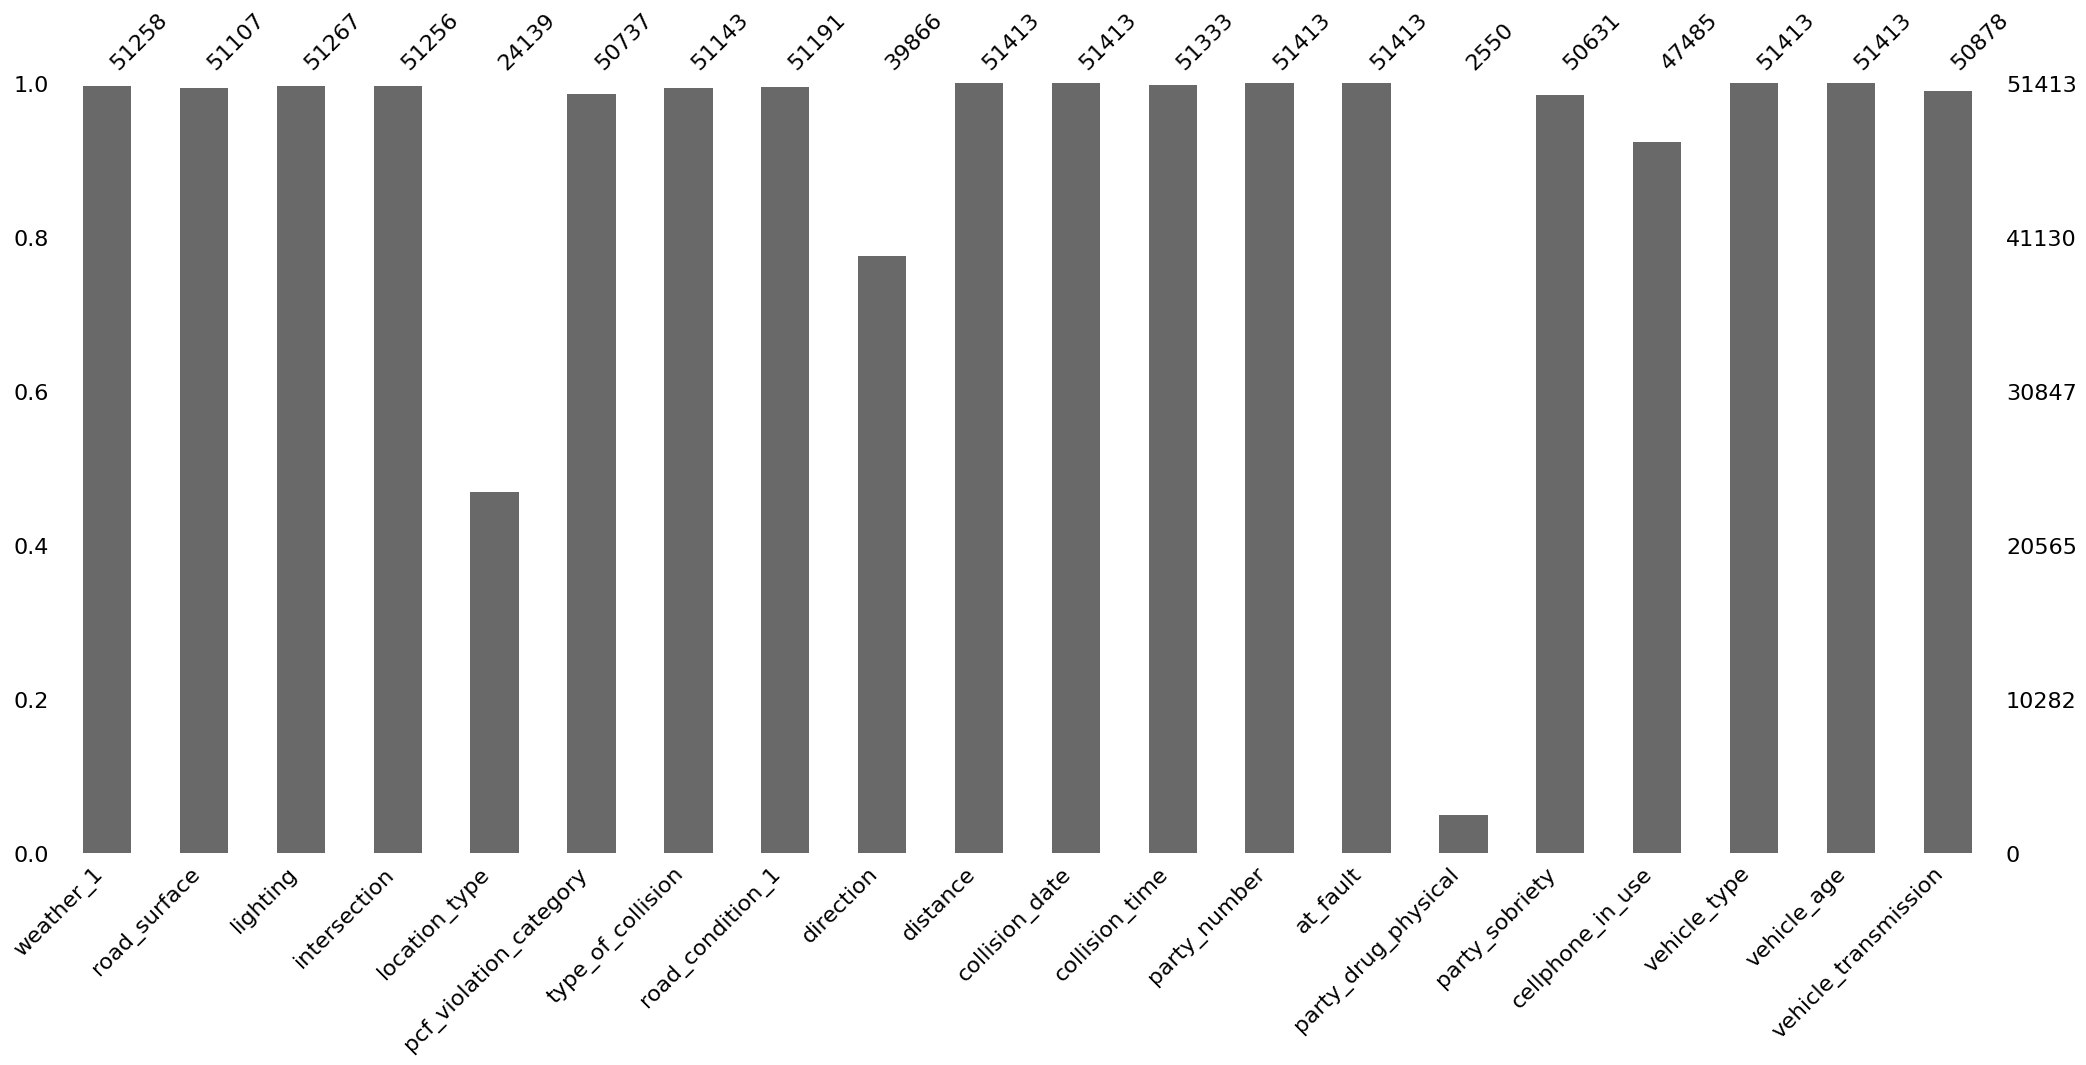

,count,mean,std,min,25%,50%,75%,max
intersection,51256.0,0.214960,0.410799,0.0,0.0,0.0,0.0,1.0
distance,51413.0,875.138158,7528.942804,0.0,10.0,147.0,582.0,1584000.0
party_number,51413.0,1.528582,0.664643,1.0,1.0,1.0,2.0,9.0
at_fault,51413.0,0.504833,0.499982,0.0,0.0,1.0,1.0,1.0
cellphone_in_use,47485.0,0.020491,0.141673,0.0,0.0,0.0,0.0,1.0
vehicle_age,51413.0,4.416354,2.608277,0.0,3.0,4.0,6.0,10.0


,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
0,clear,dry,dark with street lights,0.0,None,automobile right of way,broadside,normal,north,400.0,2012-04-19,22:04:00,1,1,None,had not been drinking,0.0,sedan,8,auto
1,clear,dry,dark with no street lights,0.0,None,dui,hit object,normal,east,190.0,2012-04-21,00:50:00,1,1,None,"had been drinking, under influence",0.0,sedan,6,auto
2,cloudy,dry,daylight,0.0,ramp,speeding,rear end,normal,south,350.0,2012-01-02,15:32:00,3,1,None,had not been drinking,0.0,sedan,3,manual
3,fog,dry,dark with no street lights,0.0,highway,improper turning,hit object,normal,west,400.0,2012-01-01,03:00:00,1,1,None,had not been drinking,0.0,sedan,3,manual
4,clear,dry,dusk or dawn,0.0,None,improper turning,sideswipe,normal,east,30.0,2012-01-02,17:08:00,1,1,None,had not been drinking,0.0,sedan,4,manual
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51408,clear,dry,dark with street lights,0.0,ramp,speeding,overturned,normal,south,20.0,2012-01-07,22:30:00,1,1,None,had not been drinking,0.0,coupe,9,manual
51409,clear,dry,dark with no street lights,0.0,None,wrong side of road,sideswipe,normal,east,3168.0,2012-01-19,05:48:00,3,0,None,had not been drinking,0.0,coupe,4,auto
51410,clear,dry,daylight,1.0,None,automobile right of way,broadside,normal,None,0.0,2012-01-04,12:40:00,2,0,None,had not been drinking,0.0,coupe,3,manual
51411,cloudy,wet,daylight,0.0,highway,speeding,hit object,normal,south,12144.0,2012-01-23,09:30:00,1,1,None,had not been drinking,0.0,coupe,6,manual


In [37]:
check_data(df)

Пу-пу-пу....  
1) Первое что бросается в глаза - много пропусков, но сделать мы с ними ничего не можем, поэтому заполним их как unknown  
2) У нас в основном все признаки категориальные, ок, оценим их распределение на таргет  
3) Сгруппируем по месяцам, чтобы понять сезонность ДТП  

### детальные данные

Детальнее изучим каждый признак

In [38]:
logger.info("Все столбцы таблицы:")
logger.info(", ".join(df.columns))
logger.info("="*50)

exclude_columns = ['case_id', 'collision_date', 'distance']  # для исключения

for col in df.columns:
    if col not in exclude_columns:
        display(f"{col}: ", end="")
        display(df[col].unique())

2025-11-26 12:22:46 [INFO] __main__: Все столбцы таблицы:
2025-11-26 12:22:46 [INFO] __main__: weather_1, road_surface, lighting, intersection, location_type, pcf_violation_category, type_of_collision, road_condition_1, direction, distance, collision_date, collision_time, party_number, at_fault, party_drug_physical, party_sobriety, cellphone_in_use, vehicle_type, vehicle_age, vehicle_transmission
2025-11-26 12:22:46 [INFO] __main__: ==================================================


'weather_1: '

array(['clear', 'cloudy', 'fog', 'raining', None, 'snowing', 'other',
       'wind'], dtype=object)

'road_surface: '

array(['dry', 'wet', 'snowy', None, 'slippery'], dtype=object)

'lighting: '

array(['dark with street lights', 'dark with no street lights',
       'daylight', 'dusk or dawn', None,
       'dark with street lights not functioning'], dtype=object)

'intersection: '

array([ 0.,  1., nan])

'location_type: '

array([None, 'ramp', 'highway', 'intersection'], dtype=object)

'pcf_violation_category: '

array(['automobile right of way', 'dui', 'speeding', 'improper turning',
       'unsafe starting or backing', 'unsafe lane change',
       'traffic signals and signs', 'unknown', 'improper passing',
       'other hazardous violation', 'wrong side of road',
       'other than driver (or pedestrian)', 'pedestrian violation', None,
       'following too closely', 'hazardous parking',
       'other improper driving', 'other equipment',
       'pedestrian right of way', 'impeding traffic', 'brakes',
       'fell asleep', 'lights'], dtype=object)

'type_of_collision: '

array(['broadside', 'hit object', 'rear end', 'sideswipe', 'head-on',
       None, 'overturned', 'other'], dtype=object)

'road_condition_1: '

array(['normal', 'construction', 'obstruction', 'holes', 'other', None,
       'loose material', 'flooded', 'reduced width'], dtype=object)

'direction: '

array(['north', 'east', 'south', 'west', None], dtype=object)

'collision_time: '

array([datetime.time(22, 4), datetime.time(0, 50), datetime.time(15, 32),
       ..., datetime.time(4, 3), datetime.time(4, 44),
       datetime.time(4, 47)], shape=(1436,), dtype=object)

'party_number: '

array([1, 3, 2, 4, 5, 8, 6, 7, 9])

'at_fault: '

array([1, 0])

'party_drug_physical: '

array([None, 'sleepy/fatigued', 'g', 'impairment - physical',
       'not applicable', 'under drug influence'], dtype=object)

'party_sobriety: '

array(['had not been drinking', 'had been drinking, under influence',
       'had been drinking, impairment unknown', None,
       'impairment unknown', 'not applicable',
       'had been drinking, not under influence'], dtype=object)

'cellphone_in_use: '

array([ 0., nan,  1.])

'vehicle_type: '

array(['sedan', 'coupe', 'other'], dtype=object)

'vehicle_age: '

array([ 8,  6,  3,  4,  1, 10,  7,  9,  2,  5,  0])

'vehicle_transmission: '

array(['auto', 'manual', None], dtype=object)

Есть пропуски в данных по многим признакам.  
Все категориальные пропуски заменить на unkwnown.  
Все числовые на -1.  
Но для начала визуаилизация данных

### посмотрим на выбросы

In [44]:
# я честно не понимаю смысл этого признака
# что нам даст информация что дтп произошло в 100 км от главной дороги?!

df[df['distance'] > 100000]




#  3   intersection            51256 non-null  float64
#  9   distance                51413 non-null  float64
#  12  party_number            51413 non-null  int64  
#  13  at_fault                51413 non-null  int64  
#  16  cellphone_in_use        47485 non-null  float64
#  18  vehicle_age             51413 non-null  int64  

,weather_1,road_surface,lighting,intersection,location_type,pcf_violation_category,type_of_collision,road_condition_1,direction,distance,collision_date,collision_time,party_number,at_fault,party_drug_physical,party_sobriety,cellphone_in_use,vehicle_type,vehicle_age,vehicle_transmission
10103,clear,dry,dusk or dawn,0.0,highway,improper turning,hit object,normal,west,124080.0,2012-03-28,18:59:00,1,1,None,had not been drinking,1.0,coupe,3,manual
11722,clear,dry,daylight,0.0,highway,speeding,rear end,normal,north,1584000.0,2012-05-22,15:45:00,2,1,None,had not been drinking,0.0,sedan,3,manual
24396,clear,dry,daylight,0.0,None,improper turning,overturned,normal,north,171600.0,2012-02-18,16:30:00,1,1,g,impairment unknown,0.0,coupe,5,manual


### визуализация данных

In [ ]:
plot_combined(df, col=None, target='at_fault', col_type=None, legend_loc='best')

In [ ]:
# df_for_plot = df.drop(columns=['collision_date', 'collision_time'])
plot_categorical_columns(df, col=None, target='at_fault', top_n=10)

In [ ]:
plot_scatter_with_numerical(df, target_column='at_fault')

In [ ]:
# даты
plt.figure(figsize=(12, 5))
df['collision_date'].value_counts().sort_index().plot(kind='line')
plt.title('Частота ДТП по датам')
plt.xlabel('Дата')
plt.ylabel('Количество ДТП')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df['time_interval'] = pd.to_datetime(df['collision_time'], format='%H:%M:%S').dt.floor('10min').dt.strftime('%H:%M')

plt.figure(figsize=(16, 6))
interval_counts = df['time_interval'].value_counts().sort_index()

plt.bar(range(len(interval_counts)), interval_counts.values)
plt.title('Частота ДТП по времени суток (интервалы по 10 минут)')
plt.xlabel('Временной интервал')
plt.ylabel('Количество ДТП')

x_ticks = range(len(interval_counts))
x_labels = [label if i % 6 == 0 else '' for i, label in enumerate(interval_counts.index)]
plt.xticks(x_ticks, x_labels, rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        df[col] = df[col].fillna('unknown')
    elif np.issubdtype(df[col].dtype, np.number):
        df[col] = df[col].fillna(-1)

In [ ]:
# проверяем результат
drop_duplicated(df)
check_data(df)